In [1]:
# Import scikit-learn dataset library
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
digits = datasets.load_digits()
X = digits.data

print(X.shape)

(1797, 64)


In [2]:
from scipy.spatial import distance
import random

class Clustering:
    def __init__(self, K, max_iters, epsilon, method):
        self.K = K
        self.max_iters = max_iters
        self.cluster_centers = None
        self.closest_cluster = None
        self.epsilon = epsilon
        self.method = method
        
    def fit(self, X):
        np.random.seed(5)
        random.seed(5)
        # Pick k random points as cluster centers
        self.cluster_centers = np.random.rand(self.K, X.shape[1]) * 16
        # Pick k random samples as cluster centers if Kmediods
        if (self.method == 'Kmediods'):
            for i in range (len(self.cluster_centers)):
                self.cluster_centers[i] = X[random.randrange(X.shape[0])]
        # Stores closest cluster center for corresponding data instances
        self.closest_cluster = np.zeros(X.shape[0])
        # Stores the inertia for the current iteration
        clusters_mean = self.cluster_centers_mean()
        # Stores the current iteration number
        i = 0
        # Stores a list of all iteration values
        epoch_list = []
        # Stores a list of all inertia values
        recorded_inertia = []
        while True:
            epoch_list.append(i)
            recorded_inertia.append(clusters_mean)
            
            self.assign_data(X)
            
            if (self.method == 'KMeans'):
                self.change_cluster_centers_kmeans(X)
            elif (self.method == 'Kmediods'):
                self.change_cluster_centers_kmediods(X)
            else:
                print('Invalid Clustering Method. Use \'KMeans\' or \'Kmediods\'')
            
            # Calculates the new inertia after the means have been updated
            new_clusters_mean = self.cluster_centers_mean()
            
            # Convergence Criteria
            if (abs(new_clusters_mean - clusters_mean) <= self.epsilon or i >= self.max_iters):
                epoch_list.append(i)
                recorded_inertia.append(clusters_mean)
                break
            else:
                i += 1
                clusters_mean = new_clusters_mean
        return self.closest_cluster, self.cluster_centers, epoch_list, recorded_inertia
    
    # Assign data instances to closest cluster center
    def assign_data(self, X):
        for i in range(len(X)):
            dist, cluster = np.inf, 0
            for j in range(len(self.cluster_centers)):
                if (distance.euclidean(X[i], self.cluster_centers[j]) < dist):
                    dist = distance.euclidean(X[i], self.cluster_centers[j])
                    cluster = j
            self.closest_cluster[i] = cluster
    
    # Change the cluster center to the average of the assigned points
    def change_cluster_centers_kmeans(self, X):
        for i in range(len(self.cluster_centers)):
            cluster_count, cluster_total = 0, 0
            for j in range(len(self.closest_cluster)):
                if (self.closest_cluster[j] == i):
                    cluster_count += 1
                    cluster_total += X[j]
            self.cluster_centers[i] = cluster_total / cluster_count
            
    # Change the cluster center to the point within the cluster with the minimum average distance to the rest
    def change_cluster_centers_kmediods(self, X):
        for i in range(len(self.cluster_centers)):
            minimum_dist, cluster_idx = np.inf, 0
            for j in range(len(self.closest_cluster)):
                if (self.closest_cluster[j] == i):
                    cluster_count, cluster_total = 0, 0
                    for k in range(len(self.closest_cluster)):
                        if (self.closest_cluster[k] == i):
                            cluster_count += 1
                            cluster_total += distance.euclidean(X[j], X[k])
                    if ((cluster_total / cluster_count) < minimum_dist):
                        minimum_dist = (cluster_total / cluster_count)
                        cluster_idx = j
            self.cluster_centers[i] = X[cluster_idx]
            
    # Calculates the inertia (used for stopping criteria)
    def cluster_centers_mean(self):
        clusters_total = 0
        for i in range(len(self.cluster_centers)):
            for j in range(len(self.closest_cluster)):
                if (self.closest_cluster[j] == i):
                    clusters_total += distance.euclidean(self.cluster_centers[i], self.closest_cluster[j])
        return np.sum(clusters_total)

In [3]:
# Performing k-means
kmeans = Clustering(K=10, max_iters=50, epsilon=1e-5, method='KMeans')
kmeans_predictions, kmeans_centroids, kmeans_epoch_list, kmeans_clustering_loss = kmeans.fit(X)

In [4]:
# Performing k-mediods
kmediods = Clustering(K=10, max_iters=50, epsilon=1e-5, method='Kmediods')
kmediods_prediction, kmediods_centroids, kmediods_epoch_list, kmediods_clustering_loss = kmediods.fit(X)

In [5]:
# Converting the predictions and cluster centers using t-SNE to plot this high-dimensional data
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

# Note: There are inconsistencies when it comes to plotting the centroids, which is due to how the t-SNE algorithm works
# Hence, it would be unproductive to plot them
#kmeans_centroids_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(kmeans_centroids)
#kmediods_centroids_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(kmediods_centroids)

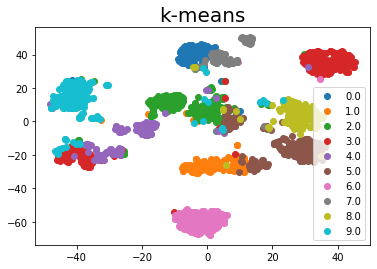

In [6]:
# Plotting k-means
u_labels = np.unique(kmeans_predictions)
for i in u_labels:
    plt.scatter(X_embedded[kmeans_predictions == i , 0] , X_embedded[kmeans_predictions == i , 1] , label = i)
#plt.scatter(kmeans_centroids_embedded[:,0] , kmeans_centroids_embedded[:,1] , s = 80, color = 'k')
plt.title("k-means", fontsize = 20)
plt.legend()
plt.show()

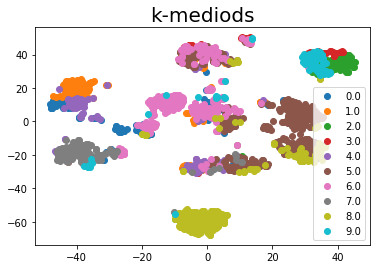

In [7]:
# Plotting k-mediods
u_labels = np.unique(kmediods_prediction)
for i in u_labels:
    plt.scatter(X_embedded[kmediods_prediction == i , 0] , X_embedded[kmediods_prediction == i , 1] , label = i)
#plt.scatter(kmediods_centroids_embedded[:,0] , kmediods_centroids_embedded[:,1] , s = 80, color = 'k')
plt.title("k-mediods", fontsize = 20)
plt.legend()
plt.show()

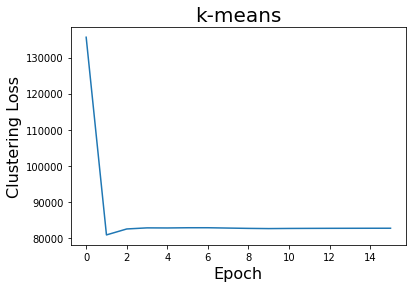

In [8]:
# Plotting Clustering Loss for k-means
def plot_loss(title, epoch_list, recorded_loss):
    plt.plot(epoch_list, recorded_loss)
    ax = plt.gca()
    ax.set_yscale("linear")
    ax.set_title(title, fontsize = 20)
    ax.set_xlabel("Epoch", fontsize = 16)
    ax.set_ylabel("Clustering Loss", fontsize = 16)
plot_loss('k-means', kmeans_epoch_list, kmeans_clustering_loss)

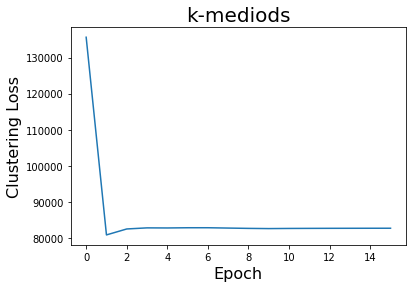

In [9]:
# Plotting Clustering Loss for k-mediods
plot_loss('k-mediods', kmeans_epoch_list, kmeans_clustering_loss)